In [1]:
import numpy as np
import os
import gzip
import struct
import random
import time

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from util import *
from node import *
from net import Net

%load_ext autoreload
%autoreload 2

In [2]:
def loadlabels(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n = struct.unpack(">ll", f.read(2*4))
        assert(_magic == 2049)
        return np.frombuffer(f.read(n), dtype=np.dtype("B"))

def loadimages(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n, sx, sy = struct.unpack(">llll", f.read(4*4))
        assert(_magic == 2051)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, sx, sy).astype(np.float32)/255.0
        return ((sx, sy), images)

def load(labelsfp, imagesfp):
    labels = loadlabels(labelsfp)
    size, images = loadimages(imagesfp)
    assert(labels.shape[0] == images.shape[0])
    return (size, labels, images)

In [3]:
ddir = "data/digits/"
print("loading train set")
imgsize, train_labels, train_images = load(ddir + "train-labels-idx1-ubyte.gz", ddir + "train-images-idx3-ubyte.gz")

print("loading test set")
_imgsize, test_labels, test_images = load(ddir + "t10k-labels-idx1-ubyte.gz", ddir + "t10k-images-idx3-ubyte.gz")

assert(imgsize == _imgsize)

loading train set
loading test set


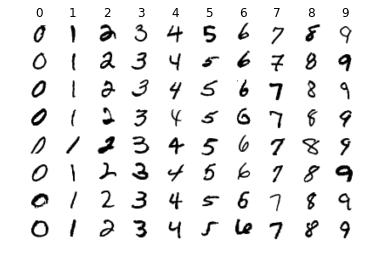

In [4]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(train_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - train_images[idx]))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

In [6]:
sx, sh, sy = imgsize[0]*imgsize[1], 30, 10
layers = [Bias(sx), Sigmoid(), Affine(sx, sh), Bias(sh), Sigmoid(), Affine(sh, sy), Bias(sy)]
links = [(i - 1, i) for i in range(len(layers))] + [len(layers) - 1, -1]
net = Net(layers, links)

In [8]:
y = net.feed(train_images[0])

TypeError: 'int' object is not subscriptable

In [11]:
batchsize = 10
rate = 3e-1
for iepoch in range(10):
    print("epoch %d:" % iepoch)
    print("train:")
    totalcost = 0.0
    tstart = time.time()
    random.shuffle(trainset)
    for batch in [trainset[p:p+batchsize] for p in range(0, len(trainset), batchsize)]:
        for digit, img in batch:
            res = np.array([i == digit for i in range(10)])
            out, netmem = feedforward(net, img, fmem=True)
            totalcost += cost(out, res)
            backprop(net, out, res, netmem, neterr)
        learn(net, neterr, rate/batchsize, adagrad)
        neterr.fill(0)
    print("cost avg: %.4f" % (totalcost/len(trainset)))
    print("time elapsed: %.2f s" % (time.time() - tstart))

    print("test:")
    totalcost = 0.0
    hitcount = 0
    tstart = time.time()
    for digit, img in testset:
        res = np.array([i == digit for i in range(10)])
        out, _ = feedforward(net, img)
        totalcost += cost(out, res)
        hitcount += digit == np.argmax(out)
    print("cost avg: %.4f" % (totalcost/len(testset)))
    print("hit count: %d / %d" % (hitcount, len(testset)))
    print("time elapsed: %.2f s" % (time.time() - tstart))

print("done")

epoch 0:
train:
cost avg: 0.0953
time elapsed: 17.27 s
test:
cost avg: 0.0747
hit count: 9292 / 10000
time elapsed: 0.48 s
epoch 1:
train:
cost avg: 0.0726
time elapsed: 16.89 s
test:
cost avg: 0.0687
hit count: 9342 / 10000
time elapsed: 0.55 s
epoch 2:
train:
cost avg: 0.0677
time elapsed: 20.24 s
test:
cost avg: 0.0656
hit count: 9375 / 10000
time elapsed: 0.45 s
epoch 3:
train:
cost avg: 0.0650
time elapsed: 20.68 s
test:
cost avg: 0.0641
hit count: 9375 / 10000
time elapsed: 1.30 s
epoch 4:
train:
cost avg: 0.0632
time elapsed: 20.32 s
test:
cost avg: 0.0632
hit count: 9380 / 10000
time elapsed: 0.52 s
epoch 5:
train:
cost avg: 0.0617
time elapsed: 15.12 s
test:
cost avg: 0.0617
hit count: 9394 / 10000
time elapsed: 0.41 s
epoch 6:
train:
cost avg: 0.0607
time elapsed: 16.59 s
test:
cost avg: 0.0614
hit count: 9386 / 10000
time elapsed: 0.47 s
epoch 7:
train:
cost avg: 0.0598
time elapsed: 16.08 s
test:
cost avg: 0.0611
hit count: 9398 / 10000
time elapsed: 0.42 s
epoch 8:
train:


In [12]:
random.shuffle(testset)
for digit, img in testset[:5]:
        out, _ = feedforward(net, img)
        display("%s: %s"  % (digit, np.argmax(out)), mkimg(img, imgsize))

'1: 1'

'0: 0'

'6: 6'

'9: 9'

'0: 0'

In [13]:
rate = 1e-1
for digit in range(10):
    img = np.random.random(net.sizes[0])*1e-2
    res = np.array([i == digit for i in range(10)])
    for i in range(1000):
        out, mem = feedforward(net, img, fmem=True)
        cv = cost(out, res)
        neterr.fill(0)
        backprop(net, out, res, mem, neterr)
        img -= rate*neterr.biases[0]
        img = np.clip(img, 0, 1)
    display(np.argmax(out), cv, mkimg(img, imgsize))

0

0.000496736855122969

1

8.595038852260855e-05

2

2.5428273331054487e-05

3

8.972776632565726e-05

4

0.00016960729717330902

5

2.3185344142863525e-05

6

0.0002010939806266625

7

8.742895787855701e-05

8

0.0028123830821686

9

7.173522811827803e-05